In [1]:
import numpy as np
import visualkeras as vk # pip install visualkeras
import pandas as pd
import seaborn as sn
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [2]:
train_data = np.load("../numpy/train_data.npy")
test_data = np.load("../numpy/test_data.npy")
train_labels = np.load("../numpy/train_labels.npy")
test_labels = np.load("../numpy/test_labels.npy")

In [3]:
model = Sequential()

model.add(Conv2D(128, (3, 3), input_shape=(48, 48, 1), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

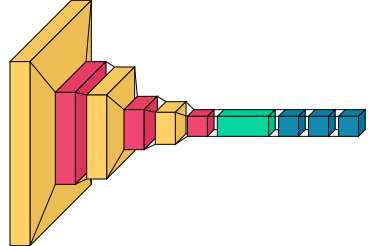

In [4]:
vk.layered_view(model)

In [5]:
datagen = ImageDataGenerator(
        rotation_range=30,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True, 
        fill_mode="nearest"
)

In [6]:
best_loss_checkpoint = ModelCheckpoint(
    filepath="../models/best_loss_model.h5",
    monitor="loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

best_val_loss_checkpoint = ModelCheckpoint(
    filepath="../models/best_val_loss_model.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

In [7]:
bs = 5

history = model.fit(
    datagen.flow(
        train_data,
        train_labels,
        batch_size=bs
    ),
    steps_per_epoch=len(train_data)//bs,
    validation_data=(test_data, test_labels),
    epochs=500,
    callbacks=[best_loss_checkpoint, best_val_loss_checkpoint]
)

Epoch 1/500
231/231 [==============================] - 10s 40ms/step - loss: 0.6838 - accuracy: 0.5688 - val_loss: 0.6932 - val_accuracy: 0.5052
Epoch 2/500
231/231 [==============================] - 10s 42ms/step - loss: 0.6259 - accuracy: 0.6242 - val_loss: 0.4175 - val_accuracy: 0.8512
Epoch 3/500
231/231 [==============================] - 11s 48ms/step - loss: 0.5123 - accuracy: 0.7619 - val_loss: 0.3047 - val_accuracy: 0.8927
Epoch 4/500
231/231 [==============================] - 11s 47ms/step - loss: 0.4732 - accuracy: 0.7749 - val_loss: 0.2702 - val_accuracy: 0.9135
Epoch 5/500
231/231 [==============================] - 11s 46ms/step - loss: 0.4413 - accuracy: 0.8035 - val_loss: 0.2471 - val_accuracy: 0.9239
Epoch 6/500
231/231 [==============================] - 11s 47ms/step - loss: 0.4010 - accuracy: 0.8216 - val_loss: 0.2481 - val_accuracy: 0.9204
Epoch 7/500
231/231 [==============================] - 10s 45ms/step - loss: 0.4079 - accuracy: 0.8147 - val_loss: 0.3424 - val_ac

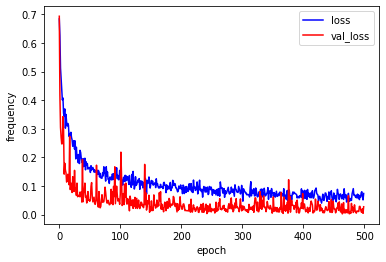

In [8]:
plt.plot(history.history["loss"], 'b', label="loss")
plt.plot(history.history["val_loss"], 'r', label="val_loss")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

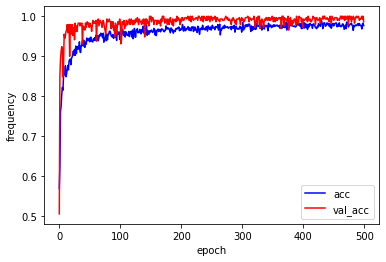

In [10]:
plt.plot(history.history["accuracy"], 'b', label="acc")
plt.plot(history.history["val_accuracy"], 'r', label="val_acc")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

In [11]:
model.load_weights('../models/best_val_loss_model.h5')

In [12]:
loss, acc = model.evaluate(test_data, test_labels)

loss, acc

10/10 [==============================] - 0s 44ms/step - loss: 0.0025 - accuracy: 1.0000


(0.0025416479911655188, 1.0)

In [13]:
predictions = model.predict(test_data)

In [14]:
confusion = confusion_matrix(
    np.argmax(test_labels, axis=1),
    np.argmax(predictions, axis=1)
)
print(confusion)

[[143   0]
 [  0 146]]


<AxesSubplot:xlabel='predicted', ylabel='actual'>

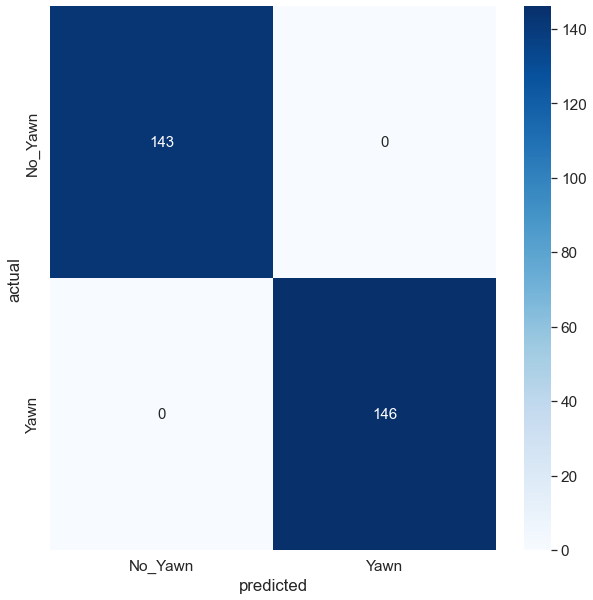

In [15]:
labels = ['No_Yawn', 'Yawn']

df_cm = pd.DataFrame(confusion, columns=np.unique(labels), index = np.unique(labels))
df_cm.index.name = 'actual'
df_cm.columns.name = 'predicted'
plt.figure(figsize = (10, 10))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 15}, fmt="d")